User Churn Prediction

Data Source: https://www.sgi.com/tech/mlc/db/churn.all
Data info: https://www.sgi.com/tech/mlc/db/churn.names
python                    2.7.13
scikit-learn              0.18.1              
scipy                     0.19.0              
seaborn                   0.8.0
pandas                    0.20.1
numpy                     1.12.1

Data Inspection

In [11]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
churn_df = pd.read_csv('data/churn.all')
num_row = churn_df.shape[0]
num_col = churn_df.shape[1]
print churn_df.head()
print 'num of rows = ' + str(num_row)
print 'num of cols = ' + str(num_col)


  state  account_length  area_code phone_number intl_plan voice_mail_plan  \
0    KS             128        415     382-4657        no             yes   
1    OH             107        415     371-7191        no             yes   
2    NJ             137        415     358-1921        no              no   
3    OH              84        408     375-9999       yes              no   
4    OK              75        415     330-6626       yes              no   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             45.07              197.4               99             16.78  

Data Cleaning

In [12]:
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

print churn_df[['voice_mail_plan','intl_plan','churned']].head()

  voice_mail_plan intl_plan churned
0             yes        no  False.
1             yes        no  False.
2              no        no  False.
3              no       yes  False.
4              no       yes  False.


Data Analysis

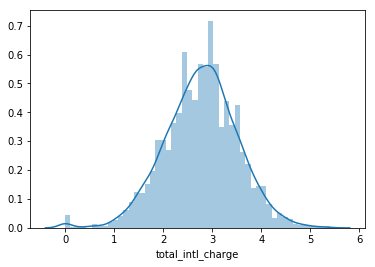

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(churn_df['total_intl_charge'])
#resmeble a Gaussian distribution

                       account_length  number_vmail_messages  \
account_length               1.000000              -0.014575   
number_vmail_messages       -0.014575               1.000000   
total_day_minutes           -0.001017               0.005381   
total_day_calls              0.028240               0.000883   
total_day_charge            -0.001019               0.005377   
total_eve_minutes           -0.009591               0.019490   
total_eve_calls              0.009143              -0.003954   
total_eve_charge            -0.009587               0.019496   
total_night_minutes          0.000668               0.005541   
total_night_calls           -0.007825               0.002676   
total_intl_minutes           0.001291               0.002463   
total_intl_calls             0.014277               0.000124   
total_intl_charge            0.001292               0.002505   

                       total_day_minutes  total_day_calls  total_day_charge  \
account_length          

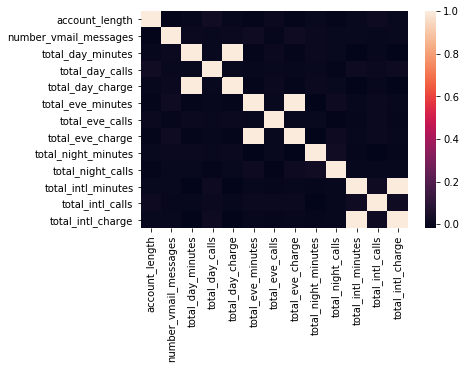

In [14]:
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()
print corr
sb.heatmap(corr)


Feature Processing

In [15]:
#get ground truth data
y = np.where(churn_df['churned'] == 'True.', 1, 0)

#drop useless infomation 
to_drop = ['state', 'area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis = 1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Converts data frame to its Numpy-array representation.
X = churn_feat_space.as_matrix().astype(np.float)

churn_feat_space.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [16]:
#Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
#remove mean and reduce to unit variance



K-fold Cross-validation

In [18]:
from sklearn.cross_validation import KFold

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.

def run_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Run Learnin Model and Evaluate

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

LR_CV_result = run_cv(X, y, LogisticRegression)
RF_CV_result = run_cv(X, y, RandomForestClassifier)
KNN_CV_result = run_cv(X, y, KNeighborsClassifier)

print ("Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result)))
print ("Random forest: " + str(accuracy(y, RF_CV_result)))
print ("K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result)))

Logistic Regression (L2 is default): 0.865
Random forest: 0.9528
K-nearest-neighbors: 0.897


In [25]:
#Show the details of prediction results
churn_df_LR_CV = churn_df
churn_df_LR_CV['LR_Predicted_churned'] = LR_CV_result == 1
churn_df_LR_CV[churn_df_LR_CV.columns[-2:]].head(10)

,churned,LR_Predicted_churned
0,False.,False
1,False.,False
2,False.,False
3,False.,False
4,False.,False
5,False.,False
6,False.,False
7,False.,False
8,False.,False
9,False.,False


Grid Search for Optimal Parameters

In [26]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [27]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5, verbose=1, refit=False)
Grid_LR.fit(X, y)

D:\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [28]:
print_grid_search_metrics(Grid_LR)

Best score: 0.865
Best parameters set:
	C: 1
	penalty: 'l1'


In [29]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(LogisticRegression(C=1,penalty='l1'), X, y, cv=5)
print ("Logistic Regression 5-fold cross validation accuracy: " + str(np.mean(score)))

Logistic Regression 5-fold cross validation accuracy: 0.865201691802


In [30]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_KNN.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   18.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=False, scoring=None, verbose=1)

In [31]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.900
Best parameters set:
	n_neighbors: 5


In [32]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(KNeighborsClassifier(n_neighbors=5),X,y,cv=5)
print "5-fold cross validation accuracy: " + str(np.mean(score))

5-fold cross validation accuracy: 0.900402120602


Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is " + str(accuracy))
    print ("Precision is " + str(precision))
    print ("Recall is " + str(recall))

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ("Random Forest", confusion_matrix(y,RF_CV_result)),
    ("K-Nearest-Neighbors", confusion_matrix(y,KNN_CV_result)),
    ("Logisitic Regression", confusion_matrix(y,LR_CV_result))
]

Random Forest
Accuracy is 0.9528
Precision is 0.990915443746
Recall is 0.955740283082


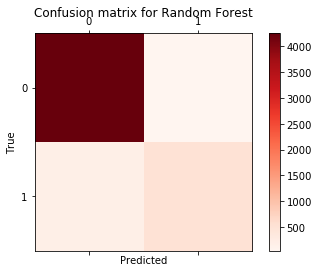

K-Nearest-Neighbors
Accuracy is 0.897
Precision is 0.985324947589
Recall is 0.903460059804


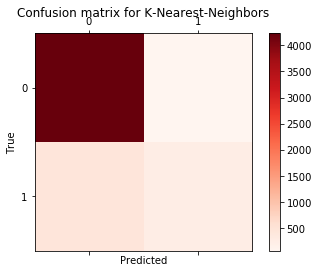

Logisitic Regression
Accuracy is 0.865
Precision is 0.974609829956
Recall is 0.880842105263


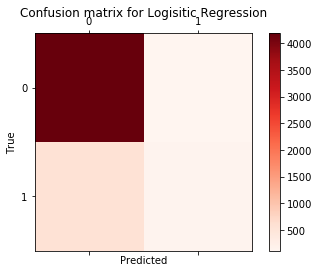

In [34]:
%matplotlib inline
draw_confusion_matrices(confusion_matrices,class_names)

Feature Selection

In [40]:
LRmodel_l1 = LogisticRegression(penalty="l1")
LRmodel_l1.fit(X, y)
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key=lambda (k,v) : (-abs(k),v)):
    print (v + ": " + str(k))
    
    
#randomly preverse one of the highly correlated features (unstable) 

Logistic Regression (L1) Coefficients
voice_mail_plan: -0.8657
number_customer_service_calls: 0.673
intl_plan: 0.613
total_day_charge: 0.4476
number_vmail_messages: 0.396
total_day_minutes: 0.2868
total_eve_minutes: 0.2734
total_intl_calls: -0.1743
total_intl_minutes: 0.1706
total_night_charge: 0.1336
total_eve_charge: 0.0843
total_intl_charge: 0.0727
total_night_minutes: 0.068
account_length: 0.0534
total_day_calls: 0.0495
total_night_calls: -0.0288
total_eve_calls: -0.0284


In [41]:
LRmodel_l2 = LogisticRegression(penalty="l2")
LRmodel_l2.fit(X, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda (k,v):(-abs(k),v)):
    print (v + ": " + str(k))

#preserve coeffcients of highly correlated features with equal weights (very robust)

Logistic Regression (L2) Coefficients
voice_mail_plan: -0.8929
number_customer_service_calls: 0.6731
intl_plan: 0.6132
number_vmail_messages: 0.4234
total_day_minutes: 0.3687
total_day_charge: 0.3664
total_eve_charge: 0.18
total_eve_minutes: 0.1794
total_intl_calls: -0.1761
total_intl_charge: 0.1235
total_intl_minutes: 0.1217
total_night_minutes: 0.1028
total_night_charge: 0.1008
account_length: 0.0552
total_day_calls: 0.0513
total_night_calls: -0.0307
total_eve_calls: -0.0304


In [43]:
from sklearn.feature_selection import RFE

rfe_l1 = RFE(LRmodel_l1, n_features_to_select=1) # If None, half of the features are selected.
rfe_l1.fit(X, y)
print "Logistic Regression (L1) RFE Result"
for k,v in sorted(zip(map(lambda x: round(x, 4), rfe_l1.ranking_), churn_feat_space.columns)):
    print v + ": " + str(k)

Logistic Regression (L1) RFE Result
total_day_minutes: 1.0
number_customer_service_calls: 2.0
intl_plan: 3.0
voice_mail_plan: 4.0
number_vmail_messages: 5.0
total_eve_minutes: 6.0
total_intl_charge: 7.0
total_night_minutes: 8.0
total_day_charge: 9.0
total_intl_calls: 10.0
total_eve_charge: 11.0
total_night_charge: 12.0
account_length: 13.0
total_day_calls: 14.0
total_intl_minutes: 15.0
total_night_calls: 16.0
total_eve_calls: 17.0


In [44]:
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print v + ": " + str(k)

Feature importance ranking by Random Forest Model:
total_day_minutes: 0.1519
total_day_charge: 0.1291
number_customer_service_calls: 0.1242
intl_plan: 0.0878
total_eve_minutes: 0.0664
total_intl_calls: 0.0615
total_eve_charge: 0.0559
total_intl_minutes: 0.0544
total_night_minutes: 0.0407
total_night_charge: 0.0371
voice_mail_plan: 0.0358
total_intl_charge: 0.0307
total_eve_calls: 0.0306
total_night_calls: 0.0256
total_day_calls: 0.0243
account_length: 0.0224
number_vmail_messages: 0.0215


Probabilty Result


In [46]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [53]:
from collections import defaultdict
true_prob = defaultdict(float)

pred_prob = run_prob_cv(X, y, RandomForestClassifier, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = (y == 1)

counts = pd.value_counts(pred_churn)
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

(5000L,)


In [48]:
EvaResults = pd.concat([counts,true_prob], axis=1).reset_index()
EvaResults.columns = ['pred_prob', 'count', 'true_prob']
EvaResults

,pred_prob,count,true_prob
0,0.0,2785,0.025135
1,0.1,1016,0.029528
2,0.2,374,0.045455
3,0.3,168,0.250000
4,0.4,77,0.363636
5,0.5,63,0.571429
6,0.6,73,0.780822
7,0.7,89,0.876404
8,0.8,110,0.972727
9,0.9,146,0.979452
